## Mask R-CNN Visualization

This notebook performs inference on a trained mask r-cnn model, and visualizes the result.

The instruction below demonstrate visualizing model performance on the validation data, and applying the model to new images.

First, create a new model, and map the weights of a previously trained model onto it.

In [ ]:
import sys
import os
import warnings
warnings.filterwarnings("ignore")
#os.environ['TF_CUDNN_DETERMINISTIC'] = 'true'
os.environ['TENSORPACK_FP16'] = 'true'
sys.path.append('/mask-rcnn-tensorflow/MaskRCNN')
import tensorflow as tf
import tqdm
import numpy as np
from model.generalized_rcnn import ResNetFPNModel
from skimage import io
import matplotlib.pyplot as plt
from config import finalize_configs, config as cfg
from dataset import DetectionDataset
from tensorpack import *
from data import get_viz_dataflow
from viz import draw_annotation, draw_final_outputs, draw_predictions, draw_proposal_recall, gt_mask, apply_masks, draw_outputs
from pathlib import Path

This next paragraph downloads a set of pretrained weights. If you are using your own model weights, you can skip this step.

In [ ]:
!wget -O /logs/train_log/example_log.tar.gz https://github.com/aws-samples/mask-rcnn-tensorflow/releases/download/v0.0.0/example_log.tar.gz && \
    cd /logs/train_log && tar -xzf /logs/train_log/example_log.tar.gz

In [ ]:
# create a mask r-cnn model
MODEL = ResNetFPNModel(True)
# file path to previoulsy trained mask r-cnn model
trained_model = '/logs/train_log/example_log/model-45000.index'
# fixed resnet50 backbone weights
cfg.BACKBONE.WEIGHTS = '/data/pretrained-models/ImageNet-R50-AlignPadding.npz'
# dataset location
# calling detection dataset gets the number of coco categories 
# and saves in the configuration
DetectionDataset()
cfg.DATA.BASEDIR = '/data/'
df = get_viz_dataflow('val2017')
df.reset_state()
finalize_configs(is_training=False)

In [ ]:
# Create an inference model
# PredictConfig takes a model, input tensors and output tensors
pred = OfflinePredictor(PredictConfig(
        model=MODEL,
        session_init=get_model_loader(trained_model),
        input_names=['images', 'orig_image_dims'],
        output_names=[
            'generate_{}_proposals_topk_per_image/boxes'.format('fpn' if cfg.MODE_FPN else 'rpn'),
            'generate_{}_proposals_topk_per_image/scores'.format('fpn' if cfg.MODE_FPN else 'rpn'),
            'fastrcnn_all_scores',
            'output/boxes',
            'output/scores',
            'output/labels',
            'output/masks'
        ]))

df is a generator that will produce images and annotations. Images are loaded in BGR format, so need to be flipped to RGB.

In [27]:
an_image = next(df.get_data())
# get image
img = an_image['images']
# flip image channels to convert BGR to RGB
img = img[:,:,[2,1,0]]
# get ground truth bounding boxes
gt_boxes = an_image['gt_boxes']
# get ground truth labels
gt_labels = an_image['gt_labels']
# get ground truth image mask
gt_masks = an_image['gt_masks']

Display the image by itself.

In [ ]:
fig,ax = plt.subplots(figsize=(img.shape[1]//50, img.shape[0]//50))
ax.imshow(img.astype(int))

Add in ground truth bounding boxes and labels using the draw_annotation function.

In [ ]:
gt_viz = draw_annotation(img, gt_boxes, gt_labels)
fig,ax = plt.subplots(figsize=(img.shape[1]//50, img.shape[0]//50))
ax.imshow(gt_viz.astype(int))

Pass this image to the model. Get region proposal network outputs and final outputs.

The pred function takes as input the original image, (with an additional dimension added, because our model expects batches), and the shape of the original image. 

It returns:
rpn_boxes: a 1000x4 size matrix specifying segmented regions of the image.

rpn_scores: length 1000 vector of the objectness score of each region, 
            the probability that the region contains an object, as opposed to background.

all_scores: 1000x81 matrix the probability of each category for each region proposal (includes 1 for background).

final_boxes: Nx4 matrix the final set of region boxes after applying non-max supression.

final_scores: length N vector of the objectness of the final boxes

final_labels: Nx81 matrix the probability of each category for final boxes (includes 1 for background).

masks: Nx28x28 tensor containing masks for each final box. Note that these need to be scaled to each box size to 
            apply to the original image

In [29]:
rpn_boxes, rpn_scores, all_scores, final_boxes, final_scores, final_labels, masks = pred(np.expand_dims(img, axis=0),
                                                                                  np.expand_dims(np.array(img.shape), axis=0))
rpn_boxes = rpn_boxes[:,1:]

First plot all rpn outputs. This is going to be a huge mess of boxes, mostly tagged as background, but worth looking at to determine how the model is working.

In [ ]:
rpn_viz = draw_predictions(img, rpn_boxes, all_scores)
fig,ax = plt.subplots(figsize=(img.shape[1]//50, img.shape[0]//50))
ax.imshow(rpn_viz.astype(int))

Let's remove all the background boxes.

In [ ]:
no_bg = np.where(all_scores.argmax(axis=1)!=0)
rpn_no_bg_viz = draw_predictions(img, rpn_boxes[no_bg], all_scores[no_bg])
fig,ax = plt.subplots(figsize=(img.shape[1]//50, img.shape[0]//50))
ax.imshow(rpn_no_bg_viz.astype(int))

After the region proposal network, the model applies a nonmax supression that removes many of the redudant boxes, then produces the model's final output. Let's plot all those final output boxes.

In [ ]:
final_all_viz = draw_outputs(img, final_boxes, final_scores, final_labels, threshold=0.0)
fig,ax = plt.subplots(figsize=(img.shape[1]//50, img.shape[0]//50))
ax.imshow(final_all_viz.astype(int))

Notice there is still some overlap, and a lot of extra boxes versus what we have on the ground truth. At this point, we want to pick a threshold for what boxes to show. Often this is set at .5 or .95. Let's try .5.

In [ ]:
final_viz = draw_outputs(img, final_boxes, final_scores, final_labels, threshold=0.5)
fig,ax = plt.subplots(figsize=(img.shape[1]//50, img.shape[0]//50))
ax.imshow(final_viz.astype(int))

This is starting to look more informative. Next, lets plot all the ground truth masks in the image.

the gt_mask function takes an image and a set of ground truth masks to overlay on the image.

In [ ]:
mask_gt_viz = gt_mask(img, gt_masks)
fig,ax = plt.subplots(figsize=(img.shape[1]//50, img.shape[0]//50))
ax.imshow(mask_gt_viz.astype(int))

And now plot our model's predictions for the masks, using the same .5 threshold for the boxes. We also now have a mask threshold. Within each box all pixels are given a probability of being part of the object. if the threshold is set at 0 the entire box will be the mask.

Note that the apply_masks function is a little more complicated than the gt_masks function. This is because apply_masks needs to take the Nx28x28 tensor of masks, as well as what boxes correspond to each mask. the final_scores are the scores for each box we used earlier. score_threshold is the same as when plotting the boxes, to avoid getting a lot of overlap. mask_threshold determines which pixels of the mask to overlay with the image.

In [ ]:
masked_box_viz = apply_masks(img, final_boxes, masks, final_scores, score_threshold=.5, mask_threshold=0.0)
fig,ax = plt.subplots(figsize=(img.shape[1]//50, img.shape[0]//50))
ax.imshow(masked_box_viz.astype(int))

If we increase the threshold, the masks will pull in tighter around the objects themselves.

In [ ]:
masked_viz = apply_masks(img, final_boxes, masks, final_scores, score_threshold=.5, mask_threshold=0.5)
fig,ax = plt.subplots(figsize=(img.shape[1]//50, img.shape[0]//50))
ax.imshow(masked_viz.astype(int))

Overlay masks and boxes from our model's predictions.

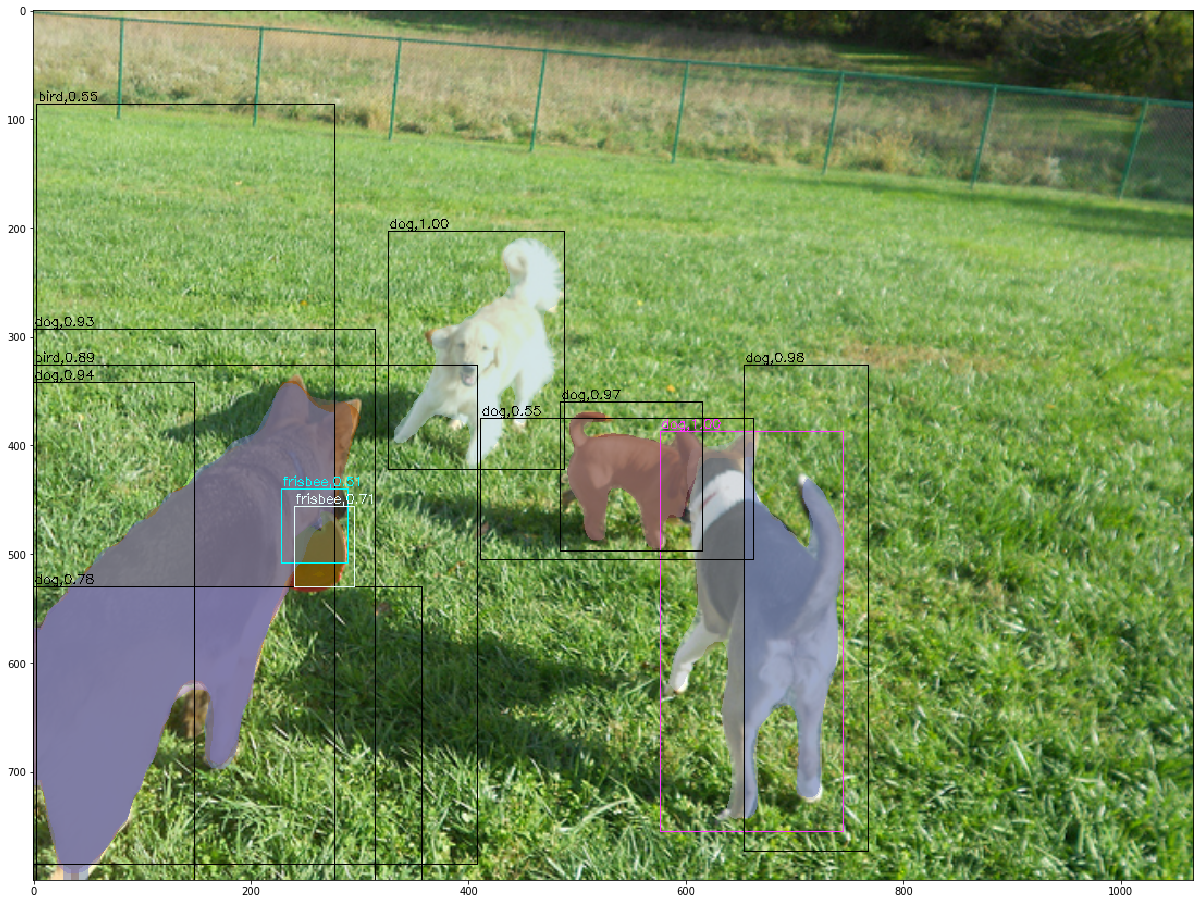

In [30]:
final_viz = draw_outputs(masked_viz, final_boxes, final_scores, final_labels, threshold=0.5)
fig,ax = plt.subplots(figsize=(img.shape[1]//50, img.shape[0]//50))
ax.imshow(final_viz.astype(int))

Now let's try a totally new image. You can use any image you want, but below we've included some examples from the validation data and from websites.

In [31]:
#images_path = np.random.choice(list(Path('/data/val2017/').glob('*.jpg')))
#images_path = "https://www.washingtonpost.com/resizer/wSFAIAbCGCi-_KhJyseh2rqSF-g=/1248x701/arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/3GGBUPK3GZA2DMKRXSKD4TP34M"
images_path = "https://i.kinja-img.com/gawker-media/image/upload/c_scale,f_auto,fl_progressive,q_80,w_1600/ekpvcpwo560egadg2mvm.jpg"
#images_path = "https://fivethirtyeight.com/wp-content/uploads/2019/11/GettyImages-1182527640-1-e1572981138469.jpg?w=1150"
#images_path = "https://fivethirtyeight.com/wp-content/uploads/2019/10/GettyImages-1001876214-4x3.jpg?w=1150"
img = io.imread(images_path)

In [ ]:
fig,ax = plt.subplots(figsize=(img.shape[1]//50, img.shape[0]//50))
ax.imshow(img.astype(int))

In [32]:
rpn_boxes, rpn_scores, all_scores, final_boxes, final_scores, final_labels, masks = pred(np.expand_dims(img, axis=0),
                                                                                  np.expand_dims(np.array(img.shape), axis=0))
rpn_boxes = rpn_boxes[:,1:]

In [ ]:
rpn_viz = draw_predictions(img, rpn_boxes, all_scores)
fig,ax = plt.subplots(figsize=(img.shape[1]//50, img.shape[0]//50))
ax.imshow(rpn_viz.astype(int))

In [ ]:
no_bg = np.where(all_scores.argmax(axis=1)!=0)
rpn_no_bg_viz = draw_predictions(img, rpn_boxes[no_bg], all_scores[no_bg])
fig,ax = plt.subplots(figsize=(img.shape[1]//50, img.shape[0]//50))
ax.imshow(rpn_no_bg_viz.astype(int))

In [ ]:
final_all_viz = draw_outputs(img, final_boxes, final_scores, final_labels, threshold=0.0)
fig,ax = plt.subplots(figsize=(img.shape[1]//50, img.shape[0]//50))
ax.imshow(final_all_viz.astype(int))

In [ ]:
final_viz = draw_outputs(img, final_boxes, final_scores, final_labels, threshold=0.75)
fig,ax = plt.subplots(figsize=(img.shape[1]//50, img.shape[0]//50))
ax.imshow(final_viz.astype(int))

In [ ]:
masked_image = apply_masks(img, final_boxes, masks, final_scores, score_threshold=.8, mask_threshold=0.5)
fig,ax = plt.subplots(figsize=(img.shape[1]//50, img.shape[0]//50))
ax.imshow(masked_image.astype(int))

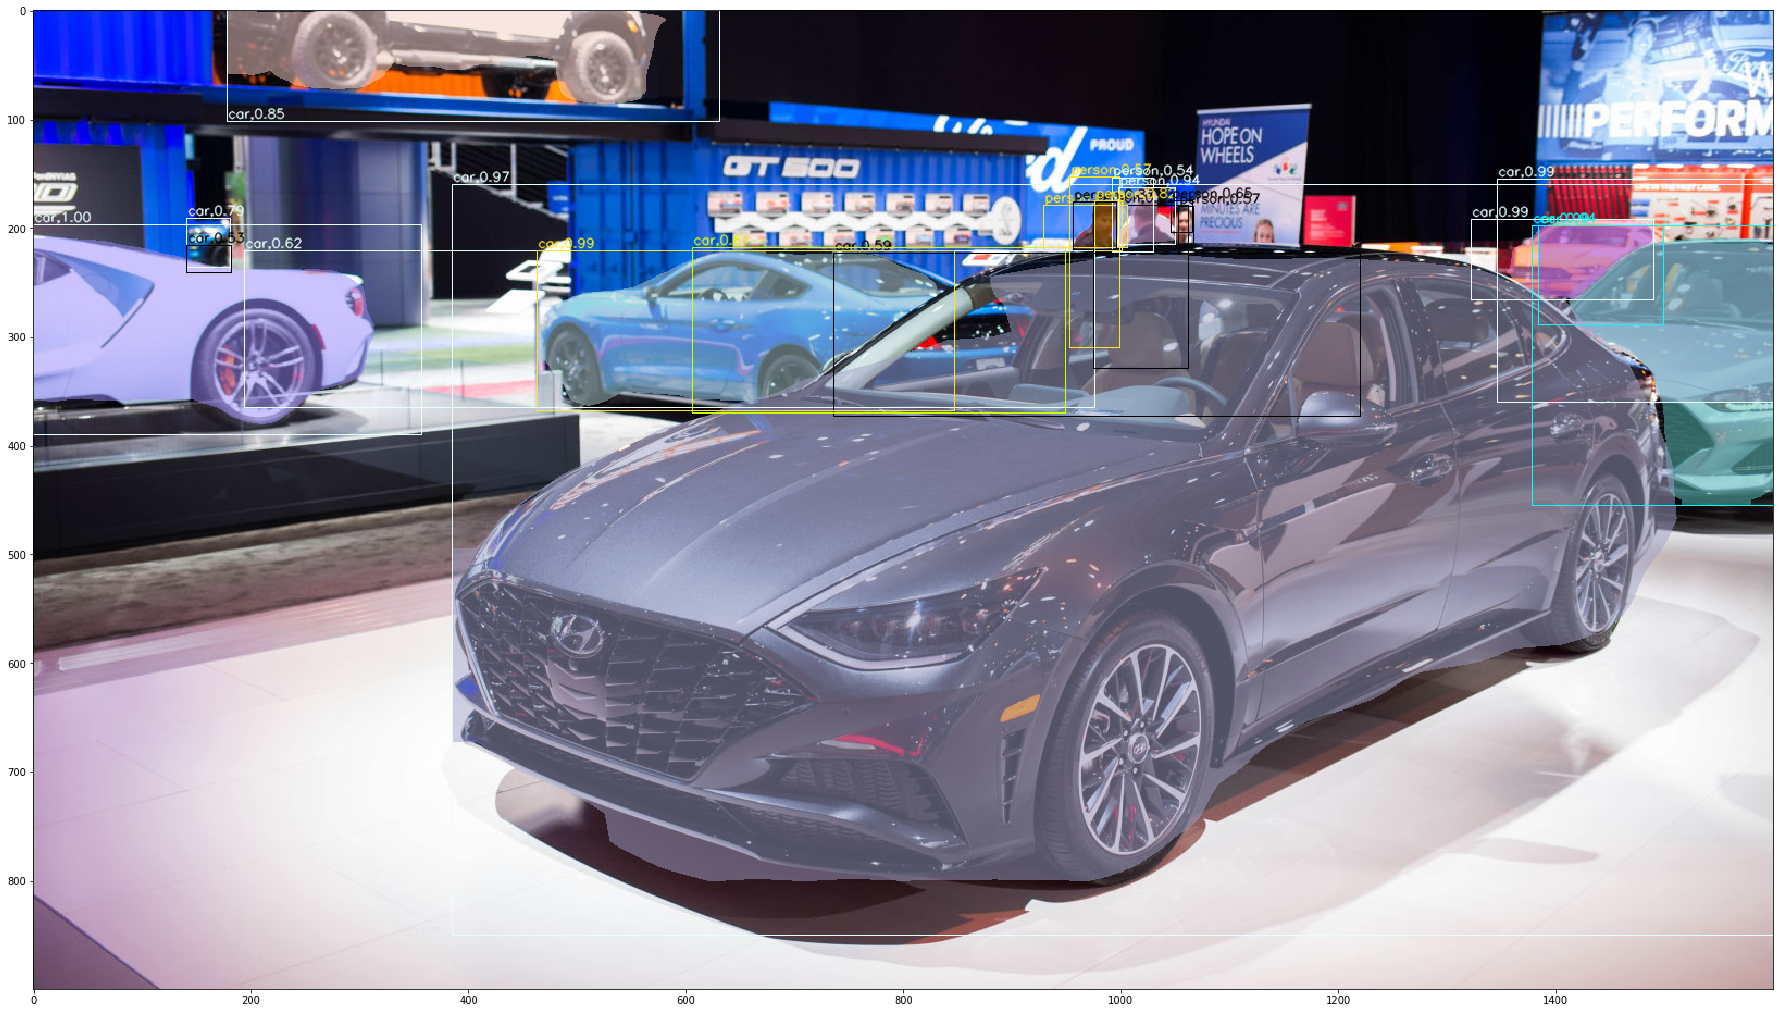

In [33]:
final_viz = draw_outputs(masked_image, final_boxes, final_scores, final_labels, threshold=0.5)
fig,ax = plt.subplots(figsize=(img.shape[1]//50, img.shape[0]//50))
ax.imshow(final_viz.astype(int))